In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def cal_significant_test(significants, proportion):
    test = np.array(significants)

    test = test[np.argsort(test[:, 2])]
    _test = np.zeros((int(test.shape[0]*proportion), 5))
    significant_set = set()
    index = 0
    for i in range(test.shape[0]):
        x, y = int(test[i, 0]), int(test[i, 1])
        flag = False
        for _x in range(x-4, x+5):
            for _y in range(y-4, y+5):
                if (_x, _y) in significant_set:
                    flag = True
                    break
            if flag:
                break
        if flag:
            continue
        significant_set.add((x, y))
        _test[index] = test[i]
        index += 1
        if index > _test.shape[0] - 1:
            break
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

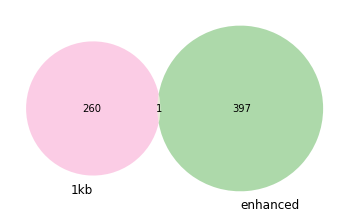

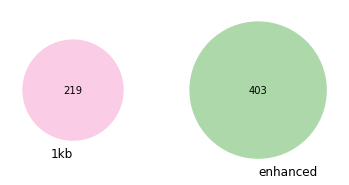

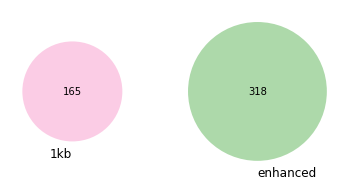

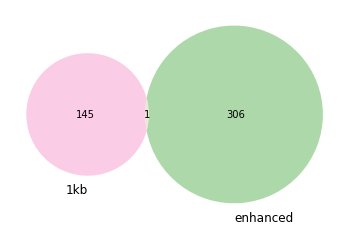

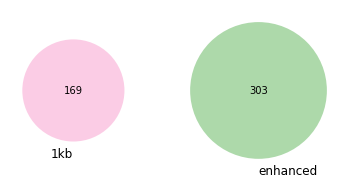

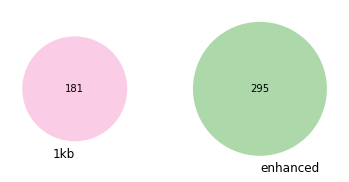

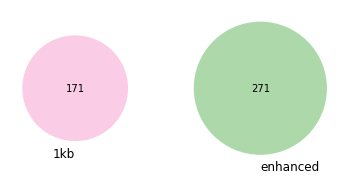

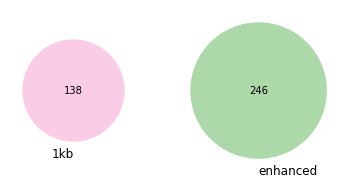

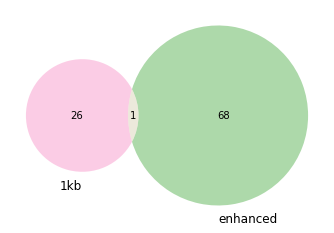

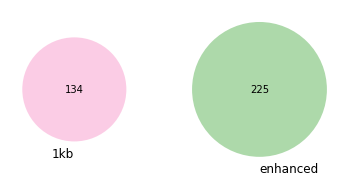

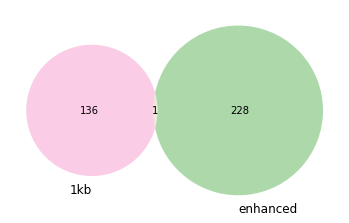

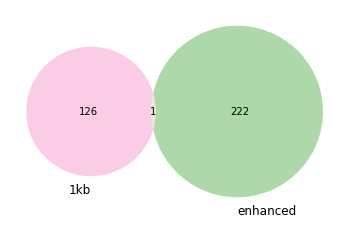

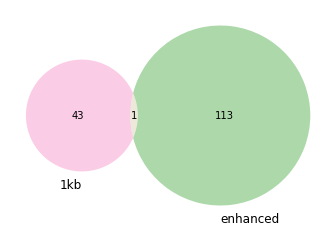

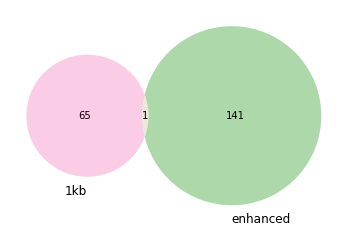

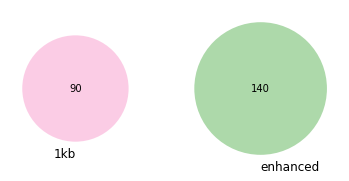

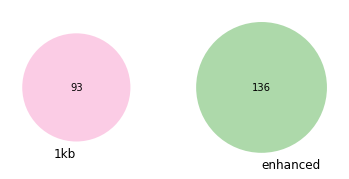

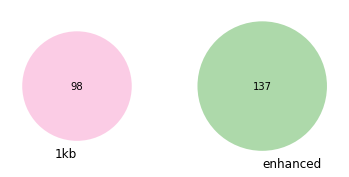

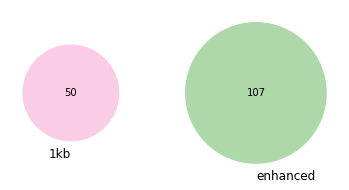

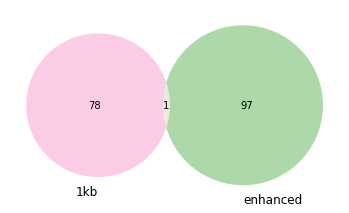

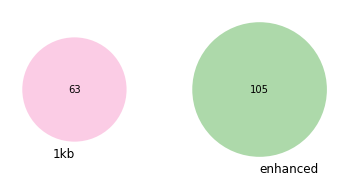

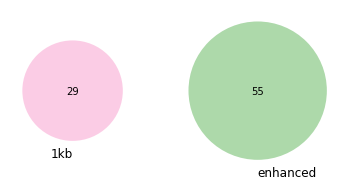

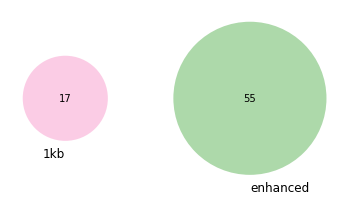

In [3]:
analyse_path = '/data1/lmh_data/MMSR_complete/analyse/K562/analyse'
enhanced_path = os.path.join(analyse_path, 'experiment_diff_loop', 'loop', 'enhanced')
hr_path = os.path.join(analyse_path, 'experiment_diff_loop', 'loop', 'hr')
proportion = 0.015

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
for chr in range(1, 23):
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'outputs_2_10', 'FitHiC.spline_pass1.res1000.significances.txt')
    hr_file_path = os.path.join(hr_path, 'chr{}_1000b'.format(chr), 'outputs_2_10', 'FitHiC.spline_pass1.res1000.significances.txt')
    enhanced_sig = cal_significant_test(get_significant(enhanced_file_path), proportion)
    hr_sig = cal_significant(get_significant(hr_file_path), proportion)
    
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig)[:, :2])))
    _hr_sig = set(list(map(tuple, np.array(hr_sig)[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

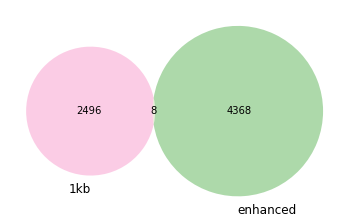

In [4]:
show_venn(enhanced_sigs, hr_sigs)

In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(51/255, 160/255, 44/255), label='mine')
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

In [6]:
tss_file_path = '/data1/lmh_data/MMSR_complete/analyse/GM12878/analyse/experiment_diff_loop/auxiliary_files/Homo_sapiens.GRCh38.104.chr.gff3'

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

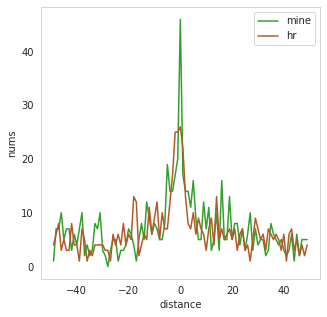

In [7]:
figure_tss(get_tss_gene_info('protein_coding')[0])

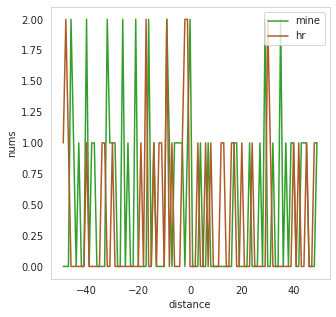

In [8]:
figure_tss(get_tss_gene_info('pseudogene')[0])

In [9]:
def get_hit_genes(significants, gene_info, genes_loop_nums):
    genes = set()
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for _info in gene_info:
            if abs(x-_info[0])<3 or abs(y-_info[0])<3:
                if _info[1] not in genes_loop_nums:
                    genes_loop_nums[_info[1]] = 1
                else:
                    genes_loop_nums[_info[1]] += 1
                genes.add((_info[1], _info[2], _info[3]))
    return genes, genes_loop_nums

def get_hit_gene_names(significants, gene_biotype='protein_coding'):
    gene_info = get_tss_gene_info(gene_biotype)[1]
    all_genes = set()
    genes_loop_nums = dict()
    for chr in range(1, 23):
        genes, genes_loop_nums = get_hit_genes(significants[chr], gene_info[chr], genes_loop_nums)
        all_genes = all_genes | genes
    return all_genes, genes_loop_nums

In [10]:
mine_hit_genes, mine_genes_loop_nums = get_hit_gene_names(all_enhanced_sig, gene_biotype='protein_coding')
mine_hit_genes = list(mine_hit_genes)
mine_hit_genes = np.array(mine_hit_genes)
print(len(mine_hit_genes))
print(mine_genes_loop_nums)

75
{'NBPF9': 4, 'NBPF11': 2, 'NBPF15': 3, 'FCGR1B': 2, 'NBPF26': 1, 'NOTCH2NLR': 1, 'CFHR3': 1, 'GPR89A': 3, 'PDZK1': 1, 'H2BC18': 2, 'H3C13': 2, 'SEC22B': 1, 'LCE3C': 2, 'OR4F5': 2, 'UNC80': 1, 'FAM237A': 1, 'COL3A1': 1, 'OR5AC2': 1, 'TAFA1': 1, 'TRIM52': 2, 'EMB': 1, 'PARP8': 1, 'ATP10B': 1, 'MOXD1': 1, 'HCRTR2': 1, 'DLC1': 1, 'C10orf90': 1, 'UTF1': 3, 'VENTX': 4, 'FUOM': 3, 'ECHS1': 1, 'PRAP1': 1, 'OR4C6': 3, 'OR5D18': 1, 'OR5L2': 1, 'OR4S2': 2, 'OR8J3': 2, 'OR8U3': 1, 'OR4A15': 1, 'OR8H2': 1, 'OR8J1': 1, 'OR8K1': 1, 'OR4A16': 1, 'TRIM64C': 2, 'OR4C16': 2, 'ANO3': 1, 'OR4C11': 3, 'OR4C15': 1, 'OR8H3': 2, 'PZP': 1, 'LMO3': 1, 'SLCO1C1': 1, 'SLC15A5': 1, 'PDE3A': 2, 'SLCO1B3-SLCO1B7': 2, 'SLCO1B3': 1, 'CCDC196': 1, 'CHRNA7': 1, 'PRDM7': 4, 'NOMO2': 1, 'IGHV3OR16-17': 1, 'MTRNR2L1': 3, 'FBXW10': 1, 'MYH8': 1, 'FOXO3B': 1, 'SERPINB4': 1, 'SERPINB11': 1, 'PSG11': 1, 'ZNF730': 1, 'ZNF675': 1, 'ZNF726': 1, 'ZNF492': 1, 'PSG3': 1, 'ZNF254': 1, 'POTEH': 1}


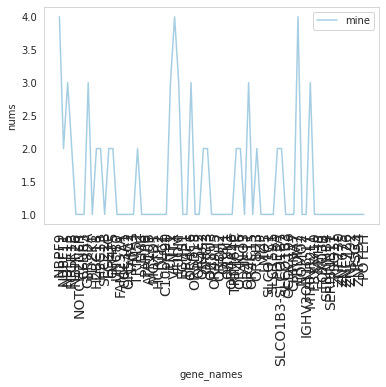

In [11]:
x = list(mine_genes_loop_nums.keys())
y = list(mine_genes_loop_nums.values())

sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color=(166/255, 206/255, 227/255), label='mine')

plt.xticks(rotation=90, fontsize=14)

# plt.ylim(0, 1)
plt.xlabel('gene_names')
plt.ylabel('nums')
# plt.xlim(0, len(significants))
plt.legend()
plt.show()

In [12]:
hr_hit_genes, hr_genes_loop_nums = get_hit_gene_names(all_hr_sig, gene_biotype='protein_coding')
hr_hit_genes = list(hr_hit_genes)
hr_hit_genes = np.array(hr_hit_genes)
print(len(hr_hit_genes))
print(hr_genes_loop_nums)

105
{'OR4F5': 8, 'HMGCS2': 1, 'SPRR5': 1, 'OR2G6': 2, 'FLG': 1, 'NBPF26': 1, 'NOTCH2NLR': 1, 'OR2W3': 1, 'PPIAL4G': 1, 'OR2M2': 1, 'UNC80': 2, 'AQP12A': 1, 'AQP12B': 1, 'FN1': 1, 'TMEFF2': 1, 'FAM237A': 1, 'CADM2': 1, 'CHST13': 1, 'POLR2H': 1, 'CLCN2': 1, 'ADCY5': 1, 'PCNP': 1, 'CABS1': 1, 'POLK': 1, 'IL13': 1, 'TSLP': 1, 'PCDHB11': 3, 'PCDHB9': 2, 'SLC9A3': 1, 'TMEM151B': 1, 'RIMS1': 1, 'KIAA0408': 1, 'TRIM73': 1, 'CTAGE6': 2, 'TRIM74': 1, 'CTAGE15': 1, 'CHN2': 1, 'FAM90A10P': 1, 'HR': 1, 'GPT': 1, 'MFSD3': 1, 'PRR23D2': 1, 'DEFB4A': 1, 'DMTN': 1, 'DEFB130B': 1, 'TDRP': 1, 'FAM110B': 1, 'DEFB103B': 1, 'ANKRD20A1': 1, 'ZMYND11': 1, 'PTPN20': 1, 'PWWP2B': 1, 'NKX6-2': 1, 'UCMA': 1, 'ADAM8': 1, 'MUC2': 1, 'TRIM49D1': 1, 'RIN1': 1, 'BRMS1': 1, 'SSU72P3': 1, 'TRIM64B': 1, 'MRPL23': 1, 'OR8K3': 1, 'ANO9': 1, 'ABCC8': 1, 'OR5F1': 1, 'TRIM49': 1, 'OR52A5': 1, 'PPP1CA': 1, 'OR10G6': 1, 'PLEKHG6': 1, 'PRB4': 1, 'MGAT4C': 1, 'RASSF8': 1, 'CD69': 1, 'HEATR4': 1, 'ACOT2': 1, 'OR11H12': 2, 'IRF2BPL

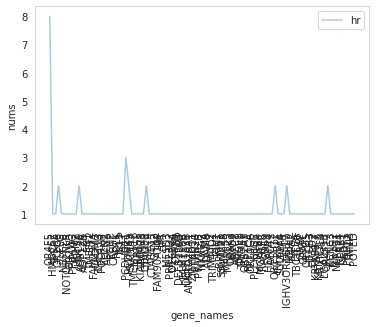

In [13]:
from matplotlib import ticker
x = list(hr_genes_loop_nums.keys())
y = list(hr_genes_loop_nums.values())

sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color=(166/255, 206/255, 227/255), label='hr')

# axes.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.xticks(rotation=90, fontsize=10)

# plt.ylim(0, 1)
plt.xlabel('gene_names', fontsize=10)
plt.ylabel('nums')
# plt.xlim(0, len(significants))
plt.legend()
plt.show()